<p align="center"><img width="50%" src="https://aimodelsharecontent.s3.amazonaws.com/aimodshare_banner.jpg" /></p>


---




<p align="center"><h1 align="center">Image Classification with PyTorch</h1> <h3 align="center">(Prepare to deploy model and preprocessor to REST API/Web Dashboard in four easy steps...)</h3></p>
<p align="center"><img width="80%" src='https://drive.google.com/thumbnail?id=1ea5R66cqAXs3g4oIeEiUUMhictrL2IBg&sz=w1200-h1200' /></p>


---



## **(1) Train Model Using `torch`**

We use the standard CIFAR-10 dataset, and train it just the way it is done in the eponymous CIFAR-10 `torch` tutorial. The caveat is that we will be loading images in `batch_size=1` inside the `DataLoader()`. NB CIFAR-10 has images of size 3x32x32 (3-channel/color images of 32x32 pixels in size).

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

`torch` datasets are PILImage images of range [0, 1]. `ToTensor()` transforms to tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, # 50000 items.
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, # 10000 items.
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


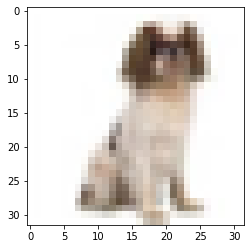

  dog


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Functions to show an image.

def imshow(img):
    img = img / 2 + 0.5 # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images.
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

Let's do a plain vanilla neural net that takes our color (3-channel) images.

In [32]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [33]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # Define a Loss function.
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Define an optimizer.

Loop over the data iterator, feed the inputs to the network and optimize.

In [34]:
for epoch in range(2):  # Loop over the dataset multiple times.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels].
        inputs, labels = data

        # Zero the parameter gradients.
        optimizer.zero_grad()

        # Forward + backward + optimize.
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # Print every 2000 mini-batches.
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.235
[1,  4000] loss: 2.040
[1,  6000] loss: 1.917
[1,  8000] loss: 1.822
[1, 10000] loss: 1.776
[1, 12000] loss: 1.759
[1, 14000] loss: 1.738
[1, 16000] loss: 1.711
[1, 18000] loss: 1.677
[1, 20000] loss: 1.645
[1, 22000] loss: 1.649
[1, 24000] loss: 1.640
[1, 26000] loss: 1.655
[1, 28000] loss: 1.562
[1, 30000] loss: 1.593
[1, 32000] loss: 1.571
[1, 34000] loss: 1.566
[1, 36000] loss: 1.555
[1, 38000] loss: 1.595
[1, 40000] loss: 1.586
[1, 42000] loss: 1.578
[1, 44000] loss: 1.527
[1, 46000] loss: 1.560
[1, 48000] loss: 1.506
[1, 50000] loss: 1.573
[2,  2000] loss: 1.499
[2,  4000] loss: 1.447
[2,  6000] loss: 1.499
[2,  8000] loss: 1.478
[2, 10000] loss: 1.493
[2, 12000] loss: 1.497
[2, 14000] loss: 1.478
[2, 16000] loss: 1.501
[2, 18000] loss: 1.492
[2, 20000] loss: 1.480
[2, 22000] loss: 1.474
[2, 24000] loss: 1.496
[2, 26000] loss: 1.503
[2, 28000] loss: 1.445
[2, 30000] loss: 1.508
[2, 32000] loss: 1.508
[2, 34000] loss: 1.496
[2, 36000] loss: 1.436
[2, 38000] 

## **(2) Save Model to ONNX**

In [35]:
model = Net()

In [36]:
model

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [37]:
dummy_input = next(iter(testloader))[0] # First observation from the batch. Tensor with shape torch.Size([1, 3, 32, 32]).

In [38]:
torch.onnx.export(
    model.cpu(),
    dummy_input,
    'my_model.onnx',
    export_params=True,
    do_constant_folding=True,
)

## **(3) Write a Preprocessor Function**

> ### Preprocessor functions for image prediction models can use ***`cv2`*** and ***`numpy`*** to read in and preprocess images. 

Since we pre-process the images using simple packages, we need to read in the CIFAR-10 dataset from the previously downloaded `cifar-10-batches-py`. Since we rely on `os` and `pickle`, we do this ouside the pre-processor function. The output is an `ndarray` for the target (images) and a list for the labels. We only load in the test-set.

In [39]:
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)

def load_CIFAR_batch(filename):
    """
    Load a single batch of CIFAR-10.
    """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1') # Python 3 and newer.
        X = datadict['data']
        y = datadict['labels']
        return X, y

def load_CIFAR10(ROOT):
    """
    Load all, in this case, the test batch of CIFAR-10.
    """
    f = os.path.join(ROOT, 'test_batch') # Load the test_batch.
    X, y = load_CIFAR_batch(f)
    return X, y

In [40]:
cifar10_dir = '/content/data/cifar-10-batches-py' # Replace with your path.

import os
from six.moves import cPickle as pickle

X, y = load_CIFAR10(cifar10_dir) # X images (targets), y labels.

`torch` tensors assume color channel is the **first** dimension, whereas `matplotlib` assumes it's the **third** dimension. Therefore always convert images (H x W x **C**) to a `torch.Tensor` of shape (**C** x H x W), and vice-versa for plotting.

In [41]:
def preprocessor(target):
        """
        This function preprocesses images in the form of ndarray, reshapes, normalizes and
        converts them to float32 for ONNX before unstacking to get the requisite format for runtime.
        
        params:
            target
                loaded images as ndarray
                      
        returns:
            preprocessed_X
                preprocessed image data
                  
        """
           
        import numpy as np

        X = target # Read in the targets.
        X = X.reshape(10000, 3, 32, 32) # Reshape to move channels last-to-first.
        X = X.astype('float32') # float32 for ONNX.
        X /= 255 # Normalization.
        *X, = X # Use the star operator to un-stack a numpy array.
        preprocessed_X = [np.expand_dims(i, axis=0) for i in X] # Adding 1 to object shape to finalize expected run-time prediction shape.                                                                            

        return preprocessed_X

In [42]:
testdata = preprocessor(target=X)

### **Test Model Output Using `onnxruntime`**

In [ ]:
!pip install onnxruntime

In [56]:
import onnxruntime as rt
modeltest = rt.InferenceSession('my_model.onnx')

input_name = modeltest.get_inputs()[0].name
input_data=testdata[3] # Needs to be float32. Try e.g. the fourth image from testdata.

res=modeltest.run(None, {input_name: input_data})
res[0]
prob = res[0]

def predict_classes(x): # Adjusted from Keras GitHub code.
        proba=x
        if proba.shape[-1] > 1:
          return proba.argmax(axis=-1)
        else:
          return (proba > 0.5).astype('int32')

prediction_index=predict_classes(prob)
def index_to_label(labels,index_n):
    return labels[index_n]
labels=['plane', 'car', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
result=list(map(lambda x: labels[x], prediction_index))

result

['plane']

### **Display a Test Model Output**

> #### Optional. NB The image may or may not match depending on how well the model learned on the training set. 

In [57]:
testpic = testdata[3] # Try e.g. the fourth image from testdata.
testpic = torch.from_numpy(testpic)

Remember, shape (H x W x **C**) for plotting.

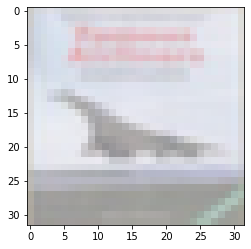

In [58]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show images.
imshow(torchvision.utils.make_grid(testpic))

## **(4) Save Preprocessor**

In [ ]:
# ! pip3 install aimodelshare

In [59]:
def export_preprocessor(preprocessor_function, filepath):
    import dill
    with open(filepath, "wb") as f:
        dill.dump(preprocessor_function, f)

# import aimodelshare as ai # Once we can deploy this, we use it in lieu of the below.
# ai.export_preprocessor(preprocessor, "preprocessor.pkl")

export_preprocessor(preprocessor, "preprocessor.pkl")